In [1]:
!nvidia-smi

Sun Oct 25 16:29:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 450.66       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:19:00.0 Off |                  Off |
| 33%   36C    P8    31W / 260W |   1014MiB / 48601MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:1A:00.0 Off |                  Off |
| 33%   

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [1]:
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch
import torch.nn as nn
import datetime
import time
%matplotlib inline
from IPython.core.debugger import set_trace
from torch_geometric.data import Data, Dataset, InMemoryDataset, DataLoader
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d, LeakyReLU, LayerNorm
from torch_geometric.nn import GCNConv, SplineConv, NNConv, DeepGCNLayer, GENConv
import pyvista as pv
from threading import Thread
import vtk
from IPython.display import HTML, display
from pyvirtualdisplay import Display
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
np.random.seed(0)
torch.manual_seed(0)
pv.set_plot_theme("document")
sns.set(color_codes=True, font_scale=1)

In [2]:
class AdditiveThermalDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, normalize=True):
        self.seq_len = 100
        self.sample_per_simulation = 100
        self.simulation_ids = [x.stem for x in Path('/home/mmv664/Documents/Graph_modeling/AutoGAMMA/2_simulation_results').iterdir() if x.is_dir()]
        self.normalize = normalize
        if normalize:
            self.stats = torch.load("/home/mmv664/Documents/Graph_modeling/Graph_AM_Modeling/processed/stats")
        super(AdditiveThermalDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['am_graph.simul0.data0']

    def download(self):
        pass
    
    def process(self):
        print('wrong place!')
            
    def len(self):
        return self.sample_per_simulation * len(self.simulation_ids) * (self.seq_len-1)

    def get(self, idx):
        i = idx//(self.sample_per_simulation * (self.seq_len-1))
        j = (idx%(self.sample_per_simulation * (self.seq_len-1)))//(self.seq_len-1)
        k = (idx%(self.sample_per_simulation * (self.seq_len-1)))%(self.seq_len-1)
        constant_data = torch.load(osp.join(self.processed_dir, 'am_graph.simul{}.const'.format(i)))
        data = torch.load(osp.join(self.processed_dir, 'am_graph.simul{}.data{}'.format(i,j)))
        smoothed = self.smooth(data['y'], base_temp = 5000)
        smoothed_laser = self.smooth(data['x'][:,:, 2:].clamp(0, 1.0), base_temp = 0.35)
        data_x = data['x'][k, :, :2]
        data_x_p1 = data['x'][k + 1, :, :]
        data_e = constant_data['edge_attr']
        data_xt = smoothed[k, :, :]
        data_y = smoothed[k + 1, :, :]
        data_xl = smoothed_laser[k, :, :]
#         data_xt = data['y'][k, :, :]
#         data_y = data['y'][k + 1, :, :]
        if self.normalize:
            # normalize boundary feature to the range of 0-1
            data_x[:,1] = (data_x[:,1] - self.stats[1,2]) / (self.stats[1,3] - self.stats[1,2])
            # normalize laser feature to mean of zeros and std of 1
#             data_x[:,2] = (data_x[:,2] - self.stats[2,2]) / (self.stats[2,3] - self.stats[2,2])
            # nomalize edge feature to mean of zero and std of 1
            data_e = 1.0/data_e**0.5
            # normalize temperature to the range of 0-1
#             data_xt = (data_xt - self.stats[3,2]) / (self.stats[3,3] - self.stats[3,2])
#             data_y = (data_y - self.stats[3,2]) / (self.stats[3,3] - self.stats[3,2])
#             data_xt = (data_xt.clamp(300, 5000) - 300) / 4700
#             data_y = (data_y.clamp(300, 5000) - 300) / 4700
            data_xt = (data_xt - 300) / 4700
            data_y = (data_y - 300) / 4700
            
        return Data(
#                     x=torch.cat((data_xt, data_x), 1), 
                    x=torch.cat((data_xt, data_x, data_xl,  data_x_p1[:,:1]), 1), 
                    y=data_y, 
                    pos=constant_data['pos'], 
                    edge_index=constant_data['edge_index'],
                    edge_attr = data_e,
                    birth_element=data['birth_element'][k + 1,:],
                    elements=constant_data['elements']
                   )
    
    def smooth(self, data, base_temp = 5000):
        added = (data - base_temp).clamp(min = 0) / 10
        final = data.clamp(max = base_temp) + added
        return final

In [5]:
dataset = AdditiveThermalDataset('/home/mmv664/Documents/Graph_modeling/Graph_AM_Modeling', normalize=True)

### Visualize databases

In [6]:
sample_num = 3

target = [dataset[sample_num*99 + time_step].y for time_step in range(99)]
target = torch.stack(target)[:,:,0] * 4700 + 300
birth = [dataset[sample_num*99 + time_step].x[:,1] for time_step in range(99)]
laser = torch.stack([dataset[sample_num*99 + time_step].x[:,3] for time_step in range(99)])
new_birth = birth[-1] - birth[0]

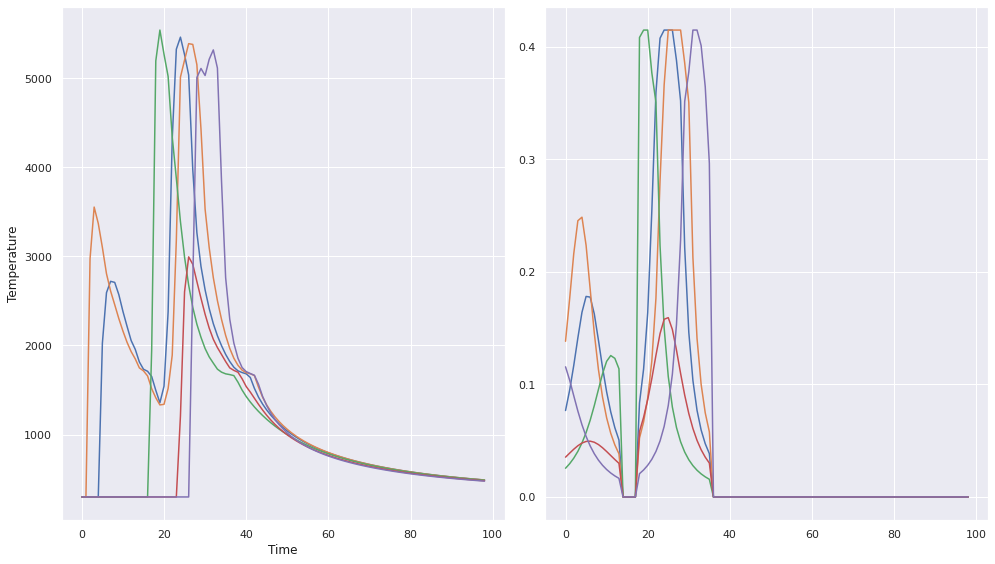

In [9]:
inds = np.random.choice(np.where(new_birth.numpy()>0)[0], 5)
samples = len(inds)

fig, axs = plt.subplots(1, 2, figsize=(14,8))
clrs = sns.color_palette(n_colors=samples)

x_range = list(range(99))
for i in range(samples):
    axs[0].plot(x_range, target[:, inds[i]], c=clrs[i])
    axs[1].plot(x_range, laser[:, inds[i]],c=clrs[i])
axs[0].set_xlabel('Time', color='k')
axs[0].set_ylabel('Temperature', color='k') 

plt.tight_layout()
plt.show()